In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
############################################import seaborn as sns
####################################################sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
# Generate data paths with labels
data_dir = "D:/CXR8/ChestX-ray"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

,filepaths,labels
0,D:/CXR8/ChestX-ray\Atelectasis\00000011_006.png,Atelectasis
1,D:/CXR8/ChestX-ray\Atelectasis\00000030_000.png,Atelectasis
2,D:/CXR8/ChestX-ray\Atelectasis\00000030_001.png,Atelectasis
3,D:/CXR8/ChestX-ray\Atelectasis\00000032_054.png,Atelectasis
4,D:/CXR8/ChestX-ray\Atelectasis\00000047_003.png,Atelectasis
...,...,...
10495,D:/CXR8/ChestX-ray\Pneumothorax\00029437_001.png,Pneumothorax
10496,D:/CXR8/ChestX-ray\Pneumothorax\00029437_002.png,Pneumothorax
10497,D:/CXR8/ChestX-ray\Pneumothorax\00029437_004.png,Pneumothorax
10498,D:/CXR8/ChestX-ray\Pneumothorax\00029437_005.png,Pneumothorax


In [6]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [7]:
# croped image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 8400 validated image filenames belonging to 15 classes.
Found 1260 validated image filenames belonging to 15 classes.
Found 840 validated image filenames belonging to 15 classes.


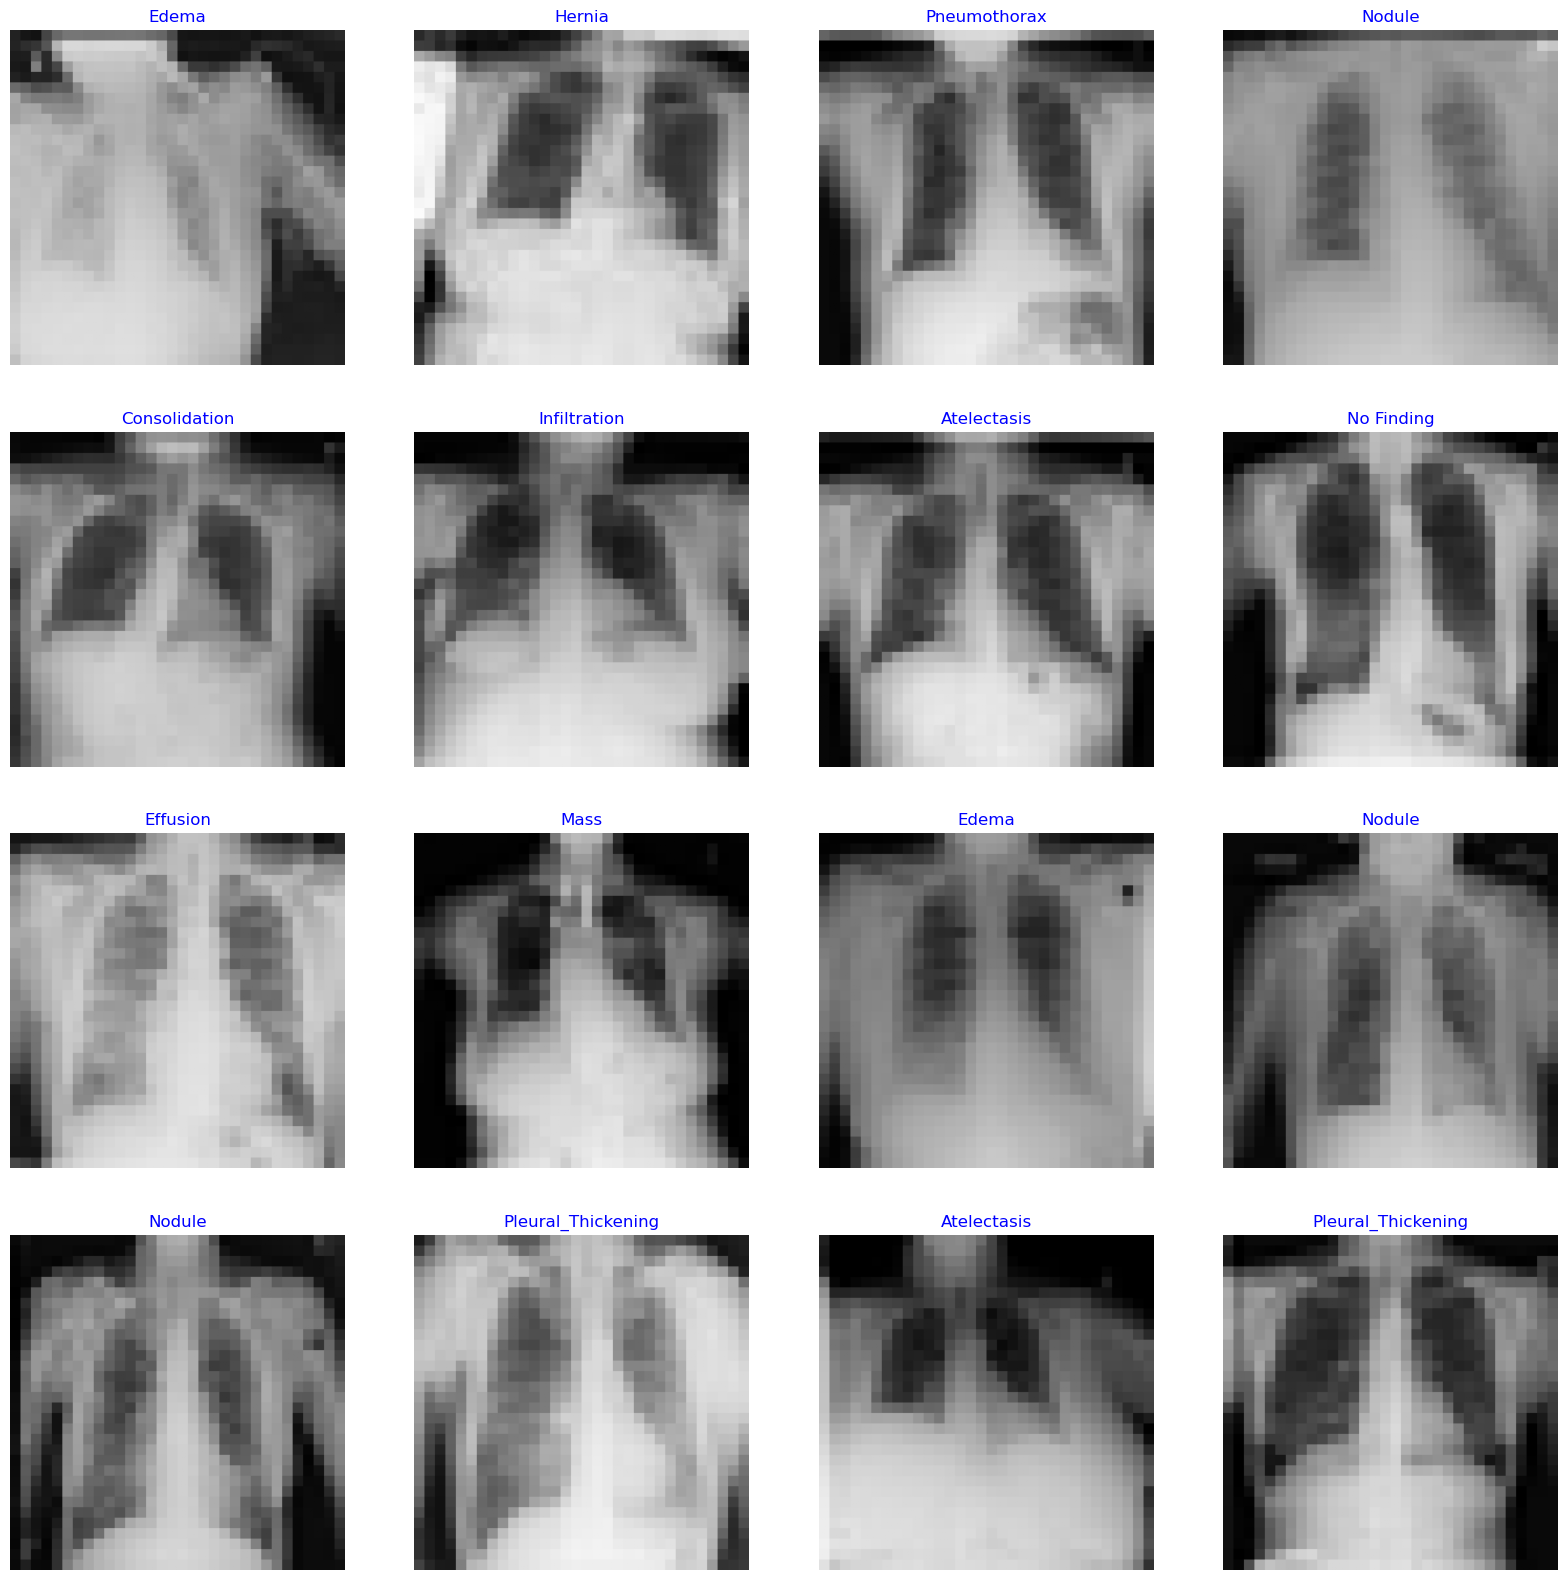

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [9]:
# Create Model Structure
#########################################################img_size = (224, 224)
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

29403144/29403144 [==============================] - 24s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1000)             7200312   
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                        

In [10]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
525/525 [==============================] - 87s 140ms/step - loss: 2.9989 - accuracy: 0.1656 - val_loss: 2.5435 - val_accuracy: 0.2159
Epoch 2/10
525/525 [==============================] - 73s 139ms/step - loss: 2.4581 - accuracy: 0.2180 - val_loss: 2.4053 - val_accuracy: 0.2341
Epoch 3/10
525/525 [==============================] - 73s 139ms/step - loss: 2.3841 - accuracy: 0.2474 - val_loss: 2.3654 - val_accuracy: 0.2563
Epoch 4/10
525/525 [==============================] - 73s 139ms/step - loss: 2.3059 - accuracy: 0.2902 - val_loss: 2.2988 - val_accuracy: 0.2913
Epoch 5/10
525/525 [==============================] - 73s 138ms/step - loss: 2.1956 - accuracy: 0.3336 - val_loss: 2.3090 - val_accuracy: 0.3087
Epoch 6/10
525/525 [==============================] - 73s 138ms/step - loss: 2.0965 - accuracy: 0.3643 - val_loss: 2.2804 - val_accuracy: 0.3151
Epoch 7/10
525/525 [==============================] - 74s 140ms/step - loss: 1.9884 - accuracy: 0.4032 - val_loss: 2.2620 - val_ac

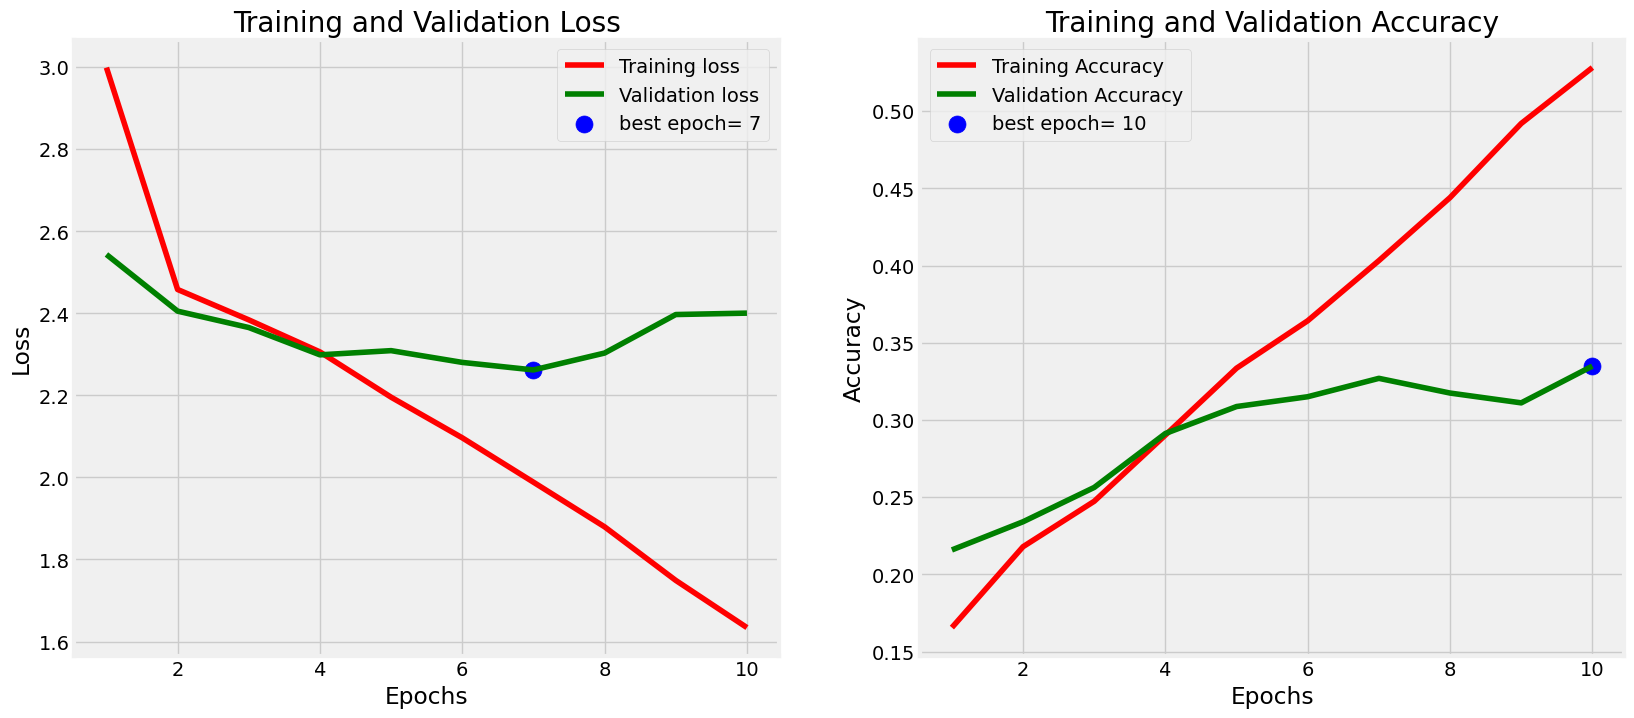

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 3s 878ms/step - loss: 0.1702 - accuracy: 1.0000
Train Loss:  0.1697542667388916
Train Accuracy:  1.0
--------------------
Validation Loss:  0.1688191294670105
Validation Accuracy:  1.0
--------------------
Test Loss:  0.17018015682697296
Test Accuracy:  1.0


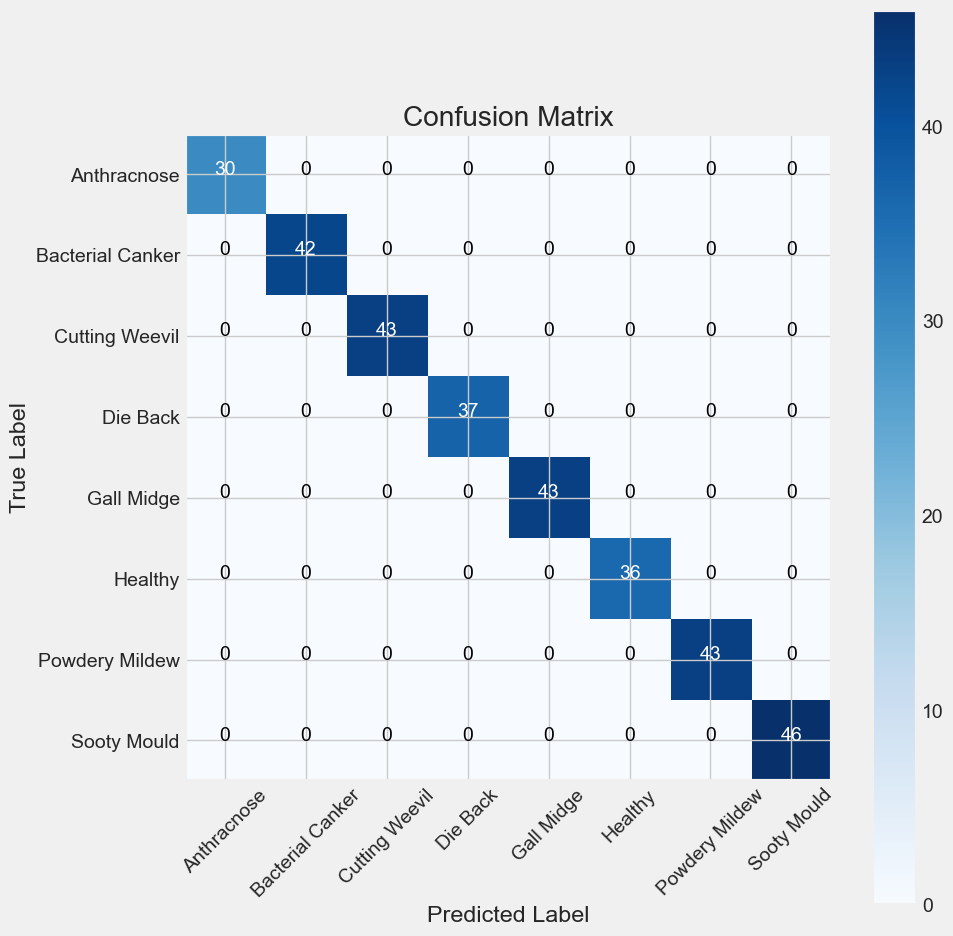

In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        30
Bacterial Canker       1.00      1.00      1.00        42
  Cutting Weevil       1.00      1.00      1.00        43
        Die Back       1.00      1.00      1.00        37
      Gall Midge       1.00      1.00      1.00        43
         Healthy       1.00      1.00      1.00        36
  Powdery Mildew       1.00      1.00      1.00        43
     Sooty Mould       1.00      1.00      1.00        46

        accuracy                           1.00       320
       macro avg       1.00      1.00      1.00       320
    weighted avg       1.00      1.00      1.00       320

